## Experimenting with discovery.flow

An example notebook for "Rapid parameter estimation for pulsar-timing-array datasets with variational inference and normalizing flows" by Vallisneri, Crisostomi, Johnson and Meyers (http://www.arxiv.org/abs/2405.08857). Very slow unless it's run with jax[cuda] on 

Note that `discovery.flow` needs `equinox`, `flowjax`, `paramax`, `optax`.

In [1]:
import sys
import os
import glob

import tqdm

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as pp

%matplotlib inline

In [3]:
import jax
jax.config.update('jax_enable_x64', True)

import jax.random
import jax.numpy as jnp

In [7]:
import discovery as ds
import discovery.flow as dsf

In [9]:
from flowjax.flows import triangular_spline_flow
from flowjax.distributions import StandardNormal

Get the 15yr nanograv dataset

In [12]:
allpsrs = [ds.Pulsar.read_feather(psrfile) for psrfile in sorted(glob.glob('../data/*-[JB]*.feather'))]

Run with fewer pulsars to converge on GPU

In [50]:
allpsrs = allpsrs[:5]

Set up a CURN likelihood, transform it so that all parameters have infinite ranges

In [51]:
Tspan = ds.getspan(allpsrs)

m2 = ds.ArrayLikelihood((ds.PulsarLikelihood([psr.residuals,
                                              ds.makenoise_measurement(psr, psr.noisedict),
                                              ds.makegp_ecorr(psr, psr.noisedict),
                                              ds.makegp_timing(psr, svd=True)]) for psr in allpsrs),
                        commongp = ds.makecommongp_fourier(allpsrs, ds.makepowerlaw_crn(14), 30, T=Tspan,
                                                           common=['crn_log10_A', 'crn_gamma'], name='red_noise'))

logx = ds.makelogtransform_uniform(m2.logL)

Set up the Monte Carlo loss, with num_samples the parallelism factor

In [52]:
num_samples = 1024
loss = dsf.value_and_grad_ElboLoss(logx, num_samples=num_samples)

Make some JAX pseudorandom keys

In [53]:
rng = jax.random.key(42)
key, flow_key, train_key = jax.random.split(rng, 3)

Define the normalizing flow

In [54]:
flow = triangular_spline_flow(flow_key,
                              base_dist=StandardNormal((len(logx.params),)), cond_dim=None,
                              flow_layers=16, knots=9, tanh_max_val=3.0, invert=False, init=None,)

Prepare the trainer (will jit the loss). Here `multibatch` can be used to extend the batch size beyond what is set in the ElboLoss. The annealing schedule is a function of the iteration number meant to soften the initial target distribution. show_progress=True will show a bar.

In [55]:
import importlib
importlib.reload(ds.flow)
importlib.reload(dsf)

<module 'discovery.flow' from '/Users/vallis/Documents/discovery/src/discovery/flow.py'>

In [56]:
trainer = dsf.VariationalFit(dist=flow, loss_fn=loss, multibatch=1,
                             learning_rate=1e-2, annealing_schedule=lambda i: min(1.0, 0.5 + 0.5*i/500),
                             show_progress=True)

CPU times: user 1.62 s, sys: 49.5 ms, total: 1.67 s
Wall time: 1.64 s


Train the network

In [57]:
train_key, trained_flow = trainer.run(train_key, steps=1001)

 76%|███████████████████████████████████████████████████████████████████████████████████▋                          | 762/1001 [14:22<04:30,  1.13s/it, loss=-915444.40]

Early stopping at iteration 762


Make samples from the flow, convert them back to physical parameters

In [58]:
ps = logx.to_df(trained_flow.sample(train_key, sample_shape=(4096 * 4,)))

Histogram!

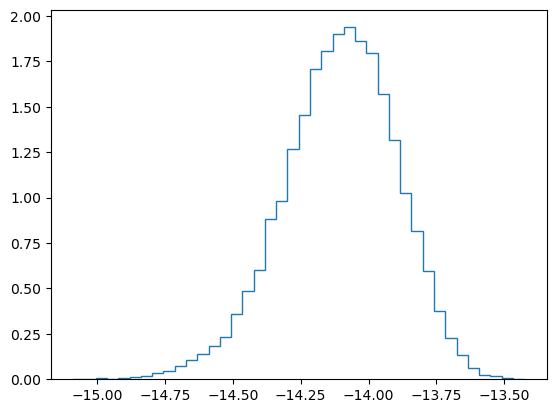

In [60]:
pp.hist(ps['crn_log10_A'], histtype='step', density=True, bins=40);